In [ ]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [ ]:
pip install nltk

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#tf.get_logger().setLevel('INFO')

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.6.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.6.0


**Functions**

In [ ]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

**Mount Google Drive**

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

**TensorFlow Datasets Information**

Get all the words in the documents (as well as the number of words in each document) by using the encoder to get the indices associated with each token and then translating the indices to tokens. But first we need to get the "unpadded" new articles so that we can get their length.

In [ ]:
#register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

2021-10-30 16:57:38.885507: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-30 16:57:38.885576: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (29c936c21721): /proc/driver/nvidia/version does not exist
I1030 16:57:38.885839 140142982784896 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
2021-10-30 16:57:38.895899: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-10-30 16:57:39.110474: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-10-30 16:57:39.308940: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empt

**Exploratory Analysis AG News Subset**

Get information about the ag_news_subset dataset. We combined the training and test data for a total of 127,600 news articles.

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    version=1.0.0,
    description='AG is a collection of more than 1 million news articles.
News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
ComeToMyHead is an academic news search engine which has been running since July, 2004.
The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
information retrieval (ranking, search, etc), xml, data compression, data streaming,
and any other non-commercial activity.
For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above.
It is used as a text classification benchmark in the following paper:
Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advanc

In [ ]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


**Review Labels (Categories)**


In [ ]:
print(f'There are {info.features["label"].num_classes} classes in the dataset.')
print(f'The class names are {info.features["label"].names}')

There are 4 classes in the dataset.
The class names are ['World', 'Sports', 'Business', 'Sci/Tech']


In [ ]:
# classes dictionary
categories =dict(enumerate(info.features["label"].names))
categories

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

The 127,600 news articles are evenly distributed among the 4 categories


In [ ]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

We will use the tf.keras.layers.experimental.preprocessing.TextVectorization layer to transform each news article into a "list" of non-negative integers representing the tokens in the news article.

For the purpose of training our models each such "encoding" will have a fixed length corresponding to the news article(s) with the most tokens. Shorter articles will be right-padded with zeros in the encoding. Also to speed up the training process, we will set max_tokens = 1000 so that words not in the vabulary set of top 1000 most common tokes are encoded as 1. But first we set max_tokens = None (which is the default value) in order to get the vocabulary size of the corpus.

In [ ]:
%%time
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=None)
encoder.adapt(dataset_all.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())

Cause: could not parse the source code of <function <lambda> at 0x7f9a50964830>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f9a50964830>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f9a50964830>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 1min 42s, sys: 11.1 s, total: 1min 54s
Wall time: 1min 19s


In [ ]:
print(f"There are {len(vocab)} vocabulary words in the corpus.")

There are 95976 vocabulary words in the corpus.


There are 95976 vocabulary words in the corpus.

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U150')

Let us get the total number of words in the corpus and the sizes of the news articles

In [ ]:
%%time
doc_sizes = []
corpus = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = encoder(example)
  doc_sizes.append(len(enc_example))
  corpus+=list(enc_example.numpy())

CPU times: user 7min 39s, sys: 10.1 s, total: 7min 49s
Wall time: 8min 21s


In [ ]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 3909695 words in the corpus of 127600 news articles.
Each news article has between 3 and 173 tokens in it.


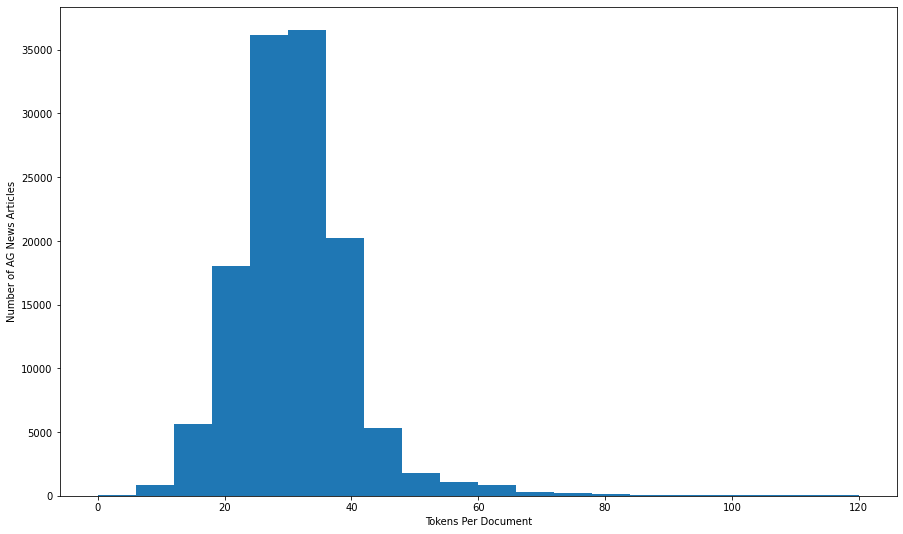

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

Encode the news articles using the top 1000 most common words in the corpus



In [ ]:
%%time
encoder_1000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000)
encoder_1000.adapt(dataset_all.map(lambda text, label: text))
vocab_1000 = np.array(encoder_1000.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7f9a72e8b4d0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f9a72e8b4d0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f9a72e8b4d0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 1min 39s, sys: 11.4 s, total: 1min 51s
Wall time: 1min 16s


The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:


In [ ]:
vocab_1000[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')


In particular, 0 is use for padding, 1 for the unknown words, 2 for the common word, i.e. 'the', etc. Let us look at the same example we encoded previously using the encoder for all the vocabulary words. Note that there are now five 1's denoting words that are not in the top 1000 in frequency.

We encode the same example as before using the new encoder. Note that there are now 5 out of vocabulary words.

In [ ]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
encoder_1000(example)

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([  2,   1,   1,  29,   3, 232,   1,  14,  19,   1,  18,   2,   1,
         8,   2, 999])>

In [ ]:
for word in example.split():
  print(f'"{word}" is {"*not* " if word not in vocab_1000  else ""}in the vocabulary.')

"the" is in the vocabulary.
"dog" is *not* in the vocabulary.
"ran" is *not* in the vocabulary.
"after" is in the vocabulary.
"a" is in the vocabulary.
"red" is in the vocabulary.
"ball" is *not* in the vocabulary.
"as" is in the vocabulary.
"it" is in the vocabulary.
"rolled" is *not* in the vocabulary.
"by" is in the vocabulary.
"the" is in the vocabulary.
"hat" is *not* in the vocabulary.
"on" is in the vocabulary.
"the" is in the vocabulary.
"ground." is *not* in the vocabulary.


We want to determine the number of non-vocabulary words in each news articles (denoted by 1s in the encoding)


In [ ]:
%%time
doc1000_sizes = []
corpus1000 = []
count1000=0
useless = 0
# stop = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  # stop+=1
  # if stop > 5: break
  enc_example = encoder_1000(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  # print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc1000_sizes.append(len(enc_example))
  corpus1000+=list(enc_example.numpy())

  count1000 += tf.math.count_nonzero(enc_example>1)

CPU times: user 8min 2s, sys: 8.3 s, total: 8min 10s
Wall time: 8min 21s


In [ ]:
print(f"Each news article has between {min(doc1000_sizes)} and {max(doc1000_sizes)} tokens in it.")

Each news article has between 3 and 173 tokens in it.


In [ ]:
Counter(percents).most_common(10)
np.unique(percents, return_counts=True)

(array([  0,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  95,  97, 100]),
 array([  12,    5,   20,   29,   49,   71,  120,  137,  172,  274,  486,
         368,  682,  777,  828, 1346, 1376, 2123, 1610, 2863, 2687, 3018,
        3957, 3315, 4605, 3934, 4148, 5737, 4954, 5072, 6123, 6165, 3255,
        5095, 4596, 3438, 5880, 4205, 3109, 4063, 3555, 3030, 2904, 2294,
        1967, 1716, 2174,  368, 2486,  234, 1246,  747,  573,  547,  520,
         441,  348,  217,  250,  135,  234,   49,  131,  101,   11,  135,
          40,  

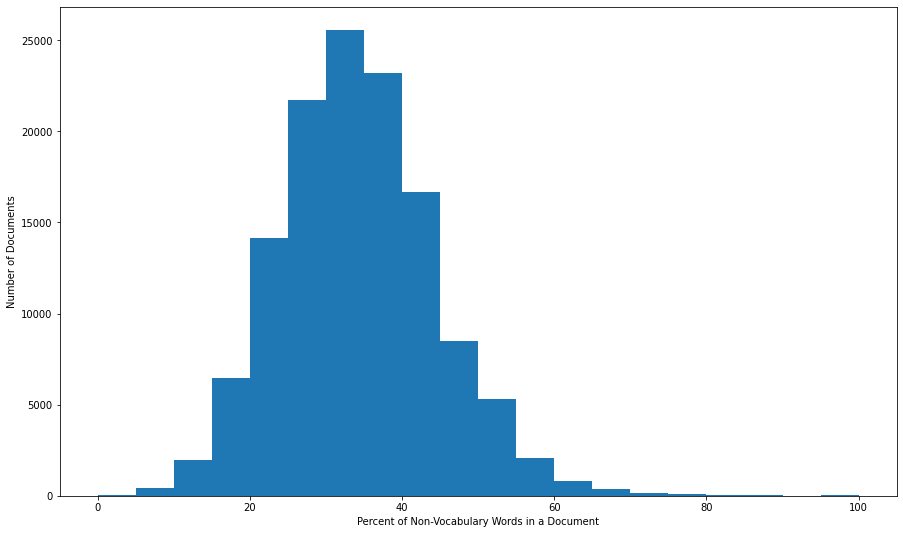

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [ ]:
print(f"There are {count1000} top {len(vocab_1000)} vocabulary words in the corpus.")

There are 2602670 top 1000 vocabulary words in the corpus.


**Preprocessing Data Create Input Pipeline**


In [ ]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2021-10-30 17:00:13.115082: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-30 17:00:13.115137: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (29c936c21721): /proc/driver/nvidia/version does not exist
I1030 17:00:13.115353 140550294378368 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I1030 17:00:13.116254 140550294378368 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I1030 17:00:13.117807 140550294378368 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I1030 17:00:13.118046 140550294378368 dataset_builder.py:299] Reusing dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
name: "ag_news_subset"
description: "AG is a collection of more than 1 million news articles.\nNews articles have

In [ ]:
####  Dataset Splits (Training, Test, Validation)
#### .8934 Training, .0470 Test, .0596 Validation

In [ ]:
len(train_dataset),len(validation_dataset),len(test_dataset) 
# len(train_dataset),len(test_dataset)

(114000, 6000, 7600)

**Review Distribution of Categorical Labels for the 114000 training data (news articles)**


In [ ]:
from collections import Counter
train_categories = [categories[label] for label in train_dataset.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Business', 28531), ('Sports', 28495), ('World', 28491), ('Sci/Tech', 28483)]

Review Example with Interger Label(text, label pairs):

Review Example with Interger Label Encoded Classification(text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


**Preprocessing Shuffle Data for Training and Create Batches of (text, label) pairs:**


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'BIRMINGHAM, Ala. Wachovia Corporation says it will build a 400 (M) million dollar data center off Lakeshore Parkway in Birmingham.'
 b'DECEMBER 08, 2004 (COMPUTERWORLD) - Some 40,000 computers in the UK #39;s Department for Work and Pensions (DWP) were unable to access their network last month when an IT technician erroneously installed a software upgrade.'
 b'It was quite simply the performance of the year for the Americans. In a perfect storm of what could go right for the US mens national team, Panama ']

labels:  [2 3 1]
texts:  [b'Using video cameras to record films in movie theaters would become a federal crime punishable by up to six years in prison under a bill passed yesterday by the House.'
 b'NASA is preparing to launch a nimble spacecraft to detect the most violent explosions in the cosmos and study their afterglow for hints of their origin.'
 b'LOS ANGELES -- Southern California seemed helpless as Aaron Rodgers picked away at its defense, hitting pass after pass

In [ ]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', [categories[n] for n in label.numpy()[:3]])
  print()

texts:  [b"AP - Political parties are the public institutions most marred by corruption, an international watchdog group said Thursday in a new global survey marking the United Nations' first International Anti-Corruption Day."
 b"AFP - It's never too late to start a new career, even if you're 96 years old -- and the new job is modelling cosmetics."
 b'Conflict seems to have become a way of life for Sudan that has struggled to find peace and stability since its independence in 1956.']

labels:  ['World', 'World', 'World']

texts:  [b'The Countryside Alliance prepares a legal challenge to the Parliament Act - used to force the hunt ban into law.'
 b'MELBOURNE (Dow Jones)--Stepping up its takeover defense from predator New Zealand Fonterra Cooperative Group Ltd. (FCO.YY), Australian dairy target National Foods Ltd.'
 b'Mahdi Army emerging as well-organized parallel government']

labels:  ['World', 'Business', 'World']



**Create the Text Encoder**

The raw text loaded by tfds needs to be processed before it can be used in a model. The simplest way to process text for training is using the experimental.preprocessing.TextVectorization layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's .adapt method: The processing of each sample contains the following steps:

standardize each sample (usually lowercasing + punctuation stripping)
split each sample into substrings (usually words)
recombine substrings into tokens (usually ngrams)
index tokens (associate a unique int value with each token)
transform each sample using this index, either into a vector of ints or a dense float vector.
The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

1000

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

In [ ]:
vocab[-20:]

array(['black', 'turn', 'build', 'countrys', 'advanced', 'whose',
       'crisis', 'create', '23', 'sources', 'body', 'militant', 'hope',
       'event', 'started', 'ready', 'jones', 'lawsuit', 'focus',
       'singapore'], dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[883,   1,   1,   1,   1,   8,  44,  10,  36,  74,  31,   1,   3,
          1,   1,   1, 228,  83, 146,   4,  40,  16, 176,   2,   1,   1,
          1,  17, 239, 548, 321,   1,   1,   4, 883,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1, 216, 749, 590,   4,   1,  32,   1,  42,  14,  38, 284,   1,
        927,   1,   1,   1, 106, 384,  12,   3,   1,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 35, 423,  66,   1,   1,  17,  44,  24, 167,  16,   1,   1,   4,
        510, 280,   6,  22, 105, 419,   8,  93,  95, 175,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for preprocessing.TextVectorization's standardize argument is "lower_and_strip_punctuation".
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Arsenal boss Arsene Wenger intimated on Tuesday that he would be signing a contact extension  quot;within days quot;. According to This is London, the Frenchman,said:  quot;I #39;ve said many times I am committed to Arsenal '
Round-trip:  arsenal [UNK] [UNK] [UNK] [UNK] on tuesday that he would be [UNK] a [UNK] [UNK] [UNK] days quot according to this is london the [UNK] [UNK] [UNK] said many times i [UNK] [UNK] to arsenal              

Original:  b'Entertainment industry executives got to strut their stuff Monday as two big traditional winter investor conferences kicked off here with a star-studded lineup.'
Round-trip:  [UNK] industry executives got to [UNK] their [UNK] monday as two big [UNK] winter [UNK] [UNK] [UNK] off here with a [UNK] [UNK]                          

Original:  b'AP - French President Jacques Chirac said Tuesday his country is "entirely committed" to taking part in an international conference on Iraq next month.'
Round-trip:  ap french president [UNK

**Create the model**

A drawing of the information flow in the model

Above is a diagram of the model.

This model can be build as a tf.keras.Sequential.

The first layer is the encoder, which converts the text to a sequence of token indices.

After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.

The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

After the RNN has converted the sequence to a single vector the two layers.Dense do some final processing, and convert from this vector representation to a single logit as the classification output.



In [ ]:
num_classes = 4
model = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

**Compile Model**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check Keras RNN guide for more details.

The embedding layer uses masking to handle the varying sequence-lengths. All the layers after the Embedding support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


**Train the model**

In [ ]:
history = model.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 233s 127ms/step - loss: 0.7126 - accuracy: 0.7334 - val_loss: 0.4945 - val_accuracy: 0.8342
Epoch 2/200
1782/1782 [==============================] - 225s 126ms/step - loss: 0.4663 - accuracy: 0.8328 - val_loss: 0.4566 - val_accuracy: 0.8393
Epoch 3/200
1782/1782 [==============================] - 224s 126ms/step - loss: 0.4427 - accuracy: 0.8401 - val_loss: 0.4411 - val_accuracy: 0.8458
Epoch 4/200
1782/1782 [==============================] - 225s 126ms/step - loss: 0.4266 - accuracy: 0.8460 - val_loss: 0.4284 - val_accuracy: 0.8460
Epoch 5/200
1782/1782 [==============================] - 224s 126ms/step - loss: 0.4086 - accuracy: 0.8523 - val_loss: 0.4051 - val_accuracy: 0.8565
Epoch 6/200
1782/1782 [==============================] - 224s 125ms/step - loss: 0.3949 - accuracy: 0.8577 - val_loss: 0.3933 - val_accuracy: 0.8565
Epoch 7/200
1782/1782 [==============================] - 225s 126ms/step - loss: 0.3855 - accuracy: 0.8601

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 4s 37ms/step - loss: 0.3932 - accuracy: 0.8570
Test Loss: 0.3932257294654846
Test Accuracy: 0.8569737076759338


**Plotting Performance Metrics - Single Layer Bidirectional RNN**

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
3,0.427,0.846,0.428,0.846
4,0.409,0.852,0.405,0.857
5,0.395,0.858,0.393,0.857
6,0.386,0.860,0.385,0.862
7,0.380,0.862,0.388,0.861
8,0.375,0.864,0.383,0.862
9,0.371,0.865,0.384,0.863
10,0.367,0.866,0.378,0.867
11,0.364,0.867,0.370,0.867
12,0.361,0.868,0.372,0.865


In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

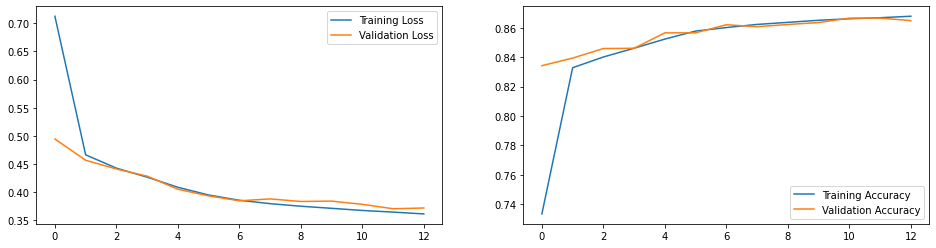

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

**Model Architecture Summary Single Layer Bidirectional RNN**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 138,564
Trainable params: 138,564
Non-trainable params: 0
_________________________________________________________________


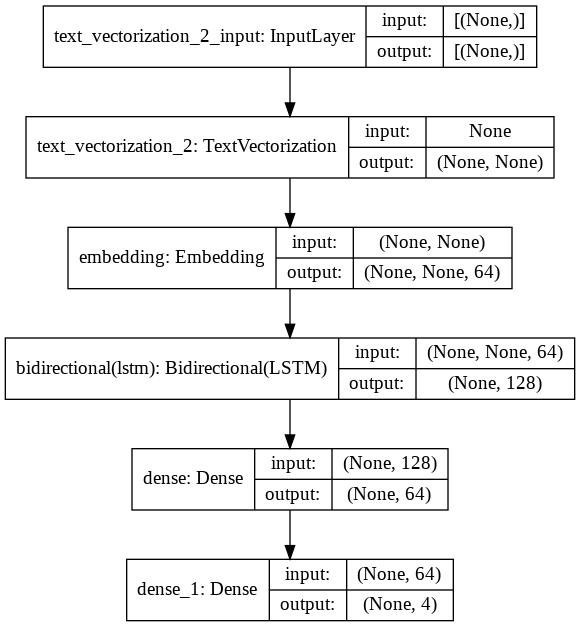

In [ ]:
keras.utils.plot_model(model, "BiDirectionalLSTM.png", show_shapes=True)

**Stack two or more LSTM layers**

Keras recurrent layers have two available modes that are controlled by the return_sequences constructor argument:

If False it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

If True the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape (batch_size, timesteps, output_features)).

Here is what the flow of information looks like with return_sequences=True:

![layered_bidirectional]?raw=1"

The interesting thing about using an RNN with return_sequences=True is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:



In [ ]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 414s 224ms/step - loss: 0.5159 - accuracy: 0.8149 - val_loss: 0.3959 - val_accuracy: 0.8656
Epoch 2/200
1782/1782 [==============================] - 397s 223ms/step - loss: 0.4264 - accuracy: 0.8514 - val_loss: 0.4430 - val_accuracy: 0.8438
Epoch 3/200
1782/1782 [==============================] - 398s 223ms/step - loss: 0.4046 - accuracy: 0.8569 - val_loss: 0.3766 - val_accuracy: 0.8578


In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 7s 58ms/step - loss: 0.4039 - accuracy: 0.8545
Test Loss: 0.4038887321949005
Test Accuracy: 0.8544737100601196


**Plotting Performance Metrics - Multi-Layer Bidirectional RNN**

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.516,0.815,0.396,0.866
1,0.426,0.851,0.443,0.844
2,0.405,0.857,0.377,0.858


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

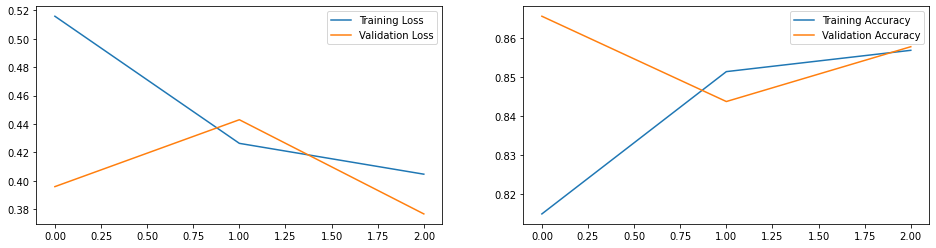

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

**Confusion Matrix**


In [ ]:
preds = model.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.04%,99.94%,0.30%,0.51%,99.86%,0.69%,0.84%,31.35%,92.50%,3.89%,99.98%,0.25%,1.81%,90.90%,99.91%
Sports,99.92%,0.00%,0.00%,99.38%,0.00%,0.07%,98.80%,64.78%,0.30%,0.04%,0.00%,0.13%,0.02%,0.50%,0.00%
Business,0.02%,0.03%,3.58%,0.06%,0.06%,14.55%,0.09%,0.31%,1.02%,78.41%,0.01%,1.65%,97.01%,2.17%,0.06%
Sci/Tech,0.01%,0.03%,96.12%,0.04%,0.08%,84.69%,0.27%,3.56%,6.18%,17.66%,0.01%,97.97%,1.16%,6.43%,0.03%


**Model Architecture Summary Single Layer Bidirectional RNN**

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

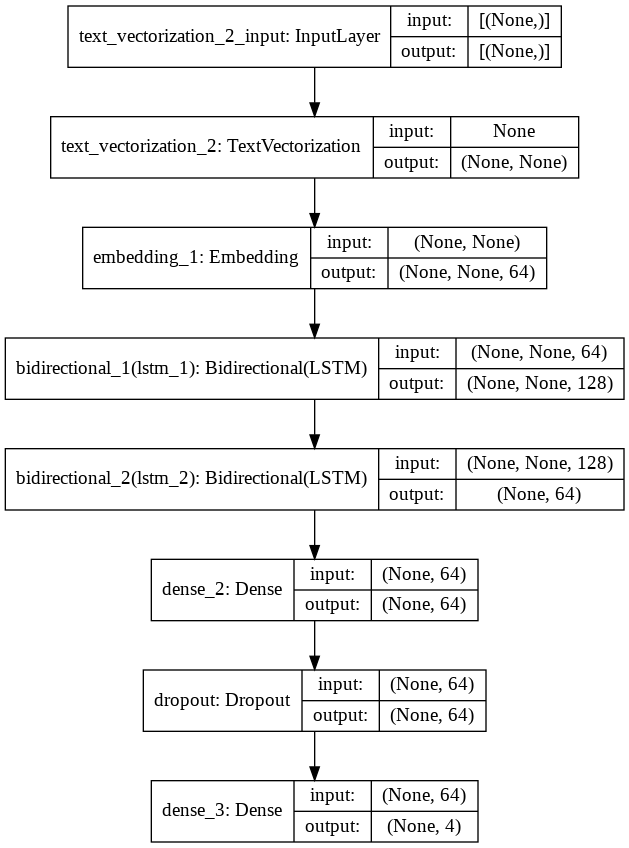

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 418s 226ms/step - loss: 0.3865 - accuracy: 0.8631 - val_loss: 0.3683 - val_accuracy: 0.8661
Epoch 2/200
1782/1782 [==============================] - 401s 225ms/step - loss: 0.3663 - accuracy: 0.8678 - val_loss: 0.3944 - val_accuracy: 0.8516
Epoch 3/200
1782/1782 [==============================] - 402s 225ms/step - loss: 0.3520 - accuracy: 0.8727 - val_loss: 0.3860 - val_accuracy: 0.8672
Epoch 4/200
1782/1782 [==============================] - 403s 226ms/step - loss: 0.3381 - accuracy: 0.8776 - val_loss: 0.3574 - val_accuracy: 0.8682
Epoch 5/200
1782/1782 [==============================] - 404s 227ms/step - loss: 0.3257 - accuracy: 0.8822 - val_loss: 0.3737 - val_accuracy: 0.8594
Epoch 6/200
1782/1782 [==============================] - 394s 221ms/step - loss: 0.3120 - accuracy: 0.8866 - val_loss: 0.3616 - val_accuracy: 0.8708
Epoch 7/200
1782/1782 [==============================] - 394s 221ms/step - loss: 0.2993 - accuracy: 0.8915

**Experiment A: EDA**

(a) Vocabulary Size: Tweak the vocabulary size, at least 3 levels.

Vocabulary of 250

In [ ]:
%%time
encoder_250 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=250)
encoder_250.adapt(dataset_all.map(lambda text, label: text))
vocab_250 = np.array(encoder_250.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7f221e309e60>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f221e309e60>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f221e309e60>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 1min 36s, sys: 11.3 s, total: 1min 47s
Wall time: 1min 15s


In [ ]:
vocab_250[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U13')

In [ ]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
encoder_250(example)

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([  2,   1,   1,  29,   3, 232,   1,  14,  19,   1,  18,   2,   1,
         8,   2,   1])>

In [ ]:
for word in example.split():
  print(f'"{word}" is {"*not* " if word not in vocab_250  else ""}in the vocabulary.')

"the" is in the vocabulary.
"dog" is *not* in the vocabulary.
"ran" is *not* in the vocabulary.
"after" is in the vocabulary.
"a" is in the vocabulary.
"red" is in the vocabulary.
"ball" is *not* in the vocabulary.
"as" is in the vocabulary.
"it" is in the vocabulary.
"rolled" is *not* in the vocabulary.
"by" is in the vocabulary.
"the" is in the vocabulary.
"hat" is *not* in the vocabulary.
"on" is in the vocabulary.
"the" is in the vocabulary.
"ground." is *not* in the vocabulary.


In [ ]:
%%time
doc250_sizes = []
corpus250 = []
count250=0
useless = 0
# stop = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  # stop+=1
  # if stop > 5: break
  enc_example = encoder_250(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  # print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc250_sizes.append(len(enc_example))
  corpus250+=list(enc_example.numpy())

  count250 += tf.math.count_nonzero(enc_example>1)

CPU times: user 8min 12s, sys: 9.26 s, total: 8min 21s
Wall time: 8min 5s


In [ ]:
print(f"Each news article has between {min(doc250_sizes)} and {max(doc250_sizes)} tokens in it.")

Each news article has between 3 and 173 tokens in it.


In [ ]:
Counter(percents).most_common(10)
np.unique(percents, return_counts=True)

(array([ 12,  13,  14,  15,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97, 100]),
 array([    2,     1,     1,     1,     4,     7,    11,    14,    18,
           38,    44,    45,    79,    84,   113,   231,   296,   360,
          583,   766,   511,  1065,  1180,  1186,  2458,  2310,  2019,
         3426,  3849,  3755,  4793,  4499,  4876,  4957,  7253,  2640,
        10073,  2458,  7656,  5276,  5124,  5102,  5197,  4532,  4426,
         3981,  2547,  2737,  3385,  1350,  1750,  1644,   531,  1603,
          920,   632,   534,   572,   241,   315,   154,   294,   119,
          117,   111

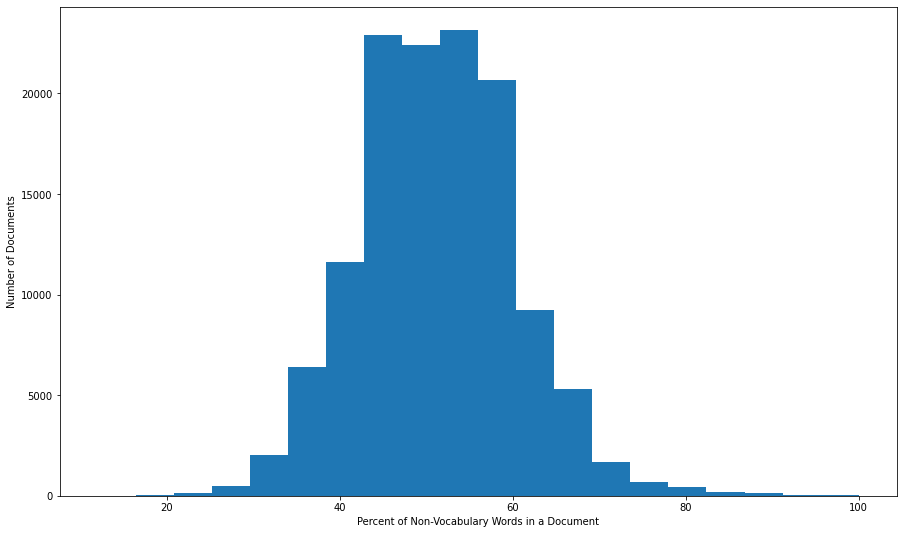

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [ ]:
print(f"There are {count250} top {len(vocab_250)} vocabulary words in the corpus.")

There are 1925982 top 250 vocabulary words in the corpus.


In [ ]:
num_classes = 4
model = tf.keras.Sequential([
                              encoder_250
                              ,tf.keras.layers.Embedding(input_dim=len(encoder_250.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )


Epoch 1/200
1782/1782 [==============================] - 253s 137ms/step - loss: 0.9113 - accuracy: 0.6353 - val_loss: 0.7215 - val_accuracy: 0.7222
Epoch 2/200
1782/1782 [==============================] - 240s 135ms/step - loss: 0.6912 - accuracy: 0.7306 - val_loss: 0.6771 - val_accuracy: 0.7398
Epoch 3/200
1782/1782 [==============================] - 240s 135ms/step - loss: 0.6598 - accuracy: 0.7436 - val_loss: 0.6416 - val_accuracy: 0.7578
Epoch 4/200
1782/1782 [==============================] - 243s 136ms/step - loss: 0.6358 - accuracy: 0.7542 - val_loss: 0.6280 - val_accuracy: 0.7595
Epoch 5/200
1782/1782 [==============================] - 243s 136ms/step - loss: 0.6240 - accuracy: 0.7590 - val_loss: 0.6172 - val_accuracy: 0.7658
Epoch 6/200
1782/1782 [==============================] - 243s 136ms/step - loss: 0.6187 - accuracy: 0.7620 - val_loss: 0.6168 - val_accuracy: 0.7608
Epoch 7/200
1782/1782 [==============================] - 242s 136ms/step - loss: 0.6137 - accuracy: 0.7629

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 5s 39ms/step - loss: 0.6212 - accuracy: 0.7609
Test Loss: 0.6211650371551514
Test Accuracy: 0.760921061038971


In [ ]:
preds = model.predict(test_dataset)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.13%,82.87%,0.41%,2.79%,97.20%,2.10%,15.93%,9.91%,74.48%,4.02%,97.98%,10.74%,17.28%,67.54%,99.55%
Sports,99.79%,3.41%,0.63%,96.28%,0.79%,0.34%,68.65%,87.64%,1.21%,0.07%,0.44%,16.14%,2.30%,15.90%,0.03%
Business,0.03%,10.23%,5.89%,0.39%,1.30%,19.47%,5.55%,0.29%,5.12%,85.45%,1.39%,5.94%,77.23%,10.59%,0.36%
Sci/Tech,0.04%,3.48%,93.07%,0.55%,0.70%,78.08%,9.87%,2.16%,19.20%,10.47%,0.19%,67.19%,3.19%,5.97%,0.06%


Vocabulary of 500

In [ ]:
%%time
encoder_500 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=500)
encoder_500.adapt(dataset_all.map(lambda text, label: text))
vocab_500 = np.array(encoder_500.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7f221dbd6170>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f221dbd6170>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f221dbd6170>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 1min 41s, sys: 11 s, total: 1min 52s
Wall time: 1min 22s


In [ ]:
vocab_500[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U13')

In [ ]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
encoder_500(example)

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([  2,   1,   1,  29,   3, 232,   1,  14,  19,   1,  18,   2,   1,
         8,   2,   1])>

In [ ]:
for word in example.split():
  print(f'"{word}" is {"*not* " if word not in vocab_500  else ""}in the vocabulary.')

"the" is in the vocabulary.
"dog" is *not* in the vocabulary.
"ran" is *not* in the vocabulary.
"after" is in the vocabulary.
"a" is in the vocabulary.
"red" is in the vocabulary.
"ball" is *not* in the vocabulary.
"as" is in the vocabulary.
"it" is in the vocabulary.
"rolled" is *not* in the vocabulary.
"by" is in the vocabulary.
"the" is in the vocabulary.
"hat" is *not* in the vocabulary.
"on" is in the vocabulary.
"the" is in the vocabulary.
"ground." is *not* in the vocabulary.


In [ ]:
%%time
doc500_sizes = []
corpus500 = []
count500=0
useless = 0
# stop = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  # stop+=1
  # if stop > 5: break
  enc_example = encoder_500(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  # print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc500_sizes.append(len(enc_example))
  corpus500+=list(enc_example.numpy())

  count500 += tf.math.count_nonzero(enc_example>1)

CPU times: user 8min 15s, sys: 9.69 s, total: 8min 25s
Wall time: 8min 9s


In [ ]:
print(f"Each news article has between {min(doc500_sizes)} and {max(doc500_sizes)} tokens in it.")

Each news article has between 3 and 173 tokens in it.


In [ ]:
Counter(percents).most_common(10)
np.unique(percents, return_counts=True)

(array([  5,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
         32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
         45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
         58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
         97, 100]),
 array([   1,    2,    9,    8,    8,   10,   21,   14,   42,   46,   59,
          98,  120,  204,  174,  365,  384,  495,  744,  733, 1150, 1142,
        1371, 2210, 2209, 2553, 3492, 3940, 2593, 3943, 4288, 3427, 6516,
        5252, 4123, 6147, 5897, 5304, 5635, 5049, 4641, 4398, 5752, 1546,
        6892, 1077, 4240, 2508, 2207, 2133, 2070, 1674, 1529, 1237,  910,
         707, 1041,  314,  502,  439,   87,  451,  180,  174,  132,  200,
          64,   97,   47,

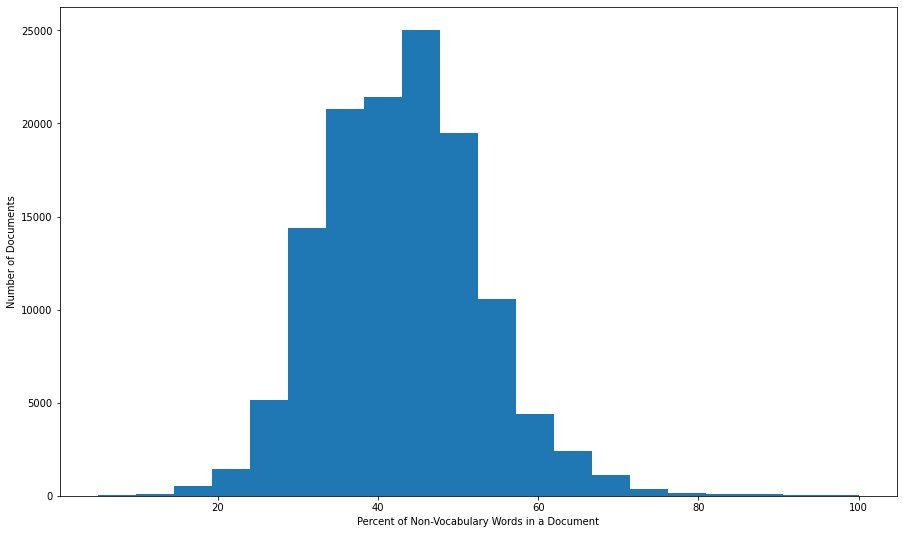

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [ ]:
print(f"There are {count500} top {len(vocab_500)} vocabulary words in the corpus.")

There are 2245833 top 500 vocabulary words in the corpus.


In [ ]:
num_classes = 4
model = tf.keras.Sequential([
                              encoder_500
                              ,tf.keras.layers.Embedding(input_dim=len(encoder_500.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 256s 139ms/step - loss: 0.5993 - accuracy: 0.7686 - val_loss: 0.6009 - val_accuracy: 0.7692
Epoch 2/200
1782/1782 [==============================] - 248s 139ms/step - loss: 0.5963 - accuracy: 0.7697 - val_loss: 0.6014 - val_accuracy: 0.7708
Epoch 3/200
1782/1782 [==============================] - 245s 137ms/step - loss: 0.5937 - accuracy: 0.7705 - val_loss: 0.6006 - val_accuracy: 0.7708
Epoch 4/200
1782/1782 [==============================] - 246s 138ms/step - loss: 0.5915 - accuracy: 0.7721 - val_loss: 0.5986 - val_accuracy: 0.7690


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 4s 37ms/step - loss: 0.6131 - accuracy: 0.7605
Test Loss: 0.6131417155265808
Test Accuracy: 0.7605262994766235


In [ ]:
preds = model.predict(test_dataset)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.07%,76.88%,0.23%,2.34%,95.65%,1.26%,13.92%,7.67%,61.44%,2.25%,96.02%,8.01%,11.92%,55.72%,99.14%
Sports,99.89%,2.21%,0.48%,97.03%,0.93%,0.35%,70.94%,90.41%,1.33%,0.07%,0.74%,12.56%,2.06%,20.60%,0.05%
Business,0.02%,17.38%,6.24%,0.31%,2.67%,19.23%,7.06%,0.28%,11.21%,88.04%,2.95%,7.89%,82.84%,16.49%,0.74%
Sci/Tech,0.02%,3.53%,93.06%,0.31%,0.76%,79.16%,8.09%,1.64%,26.01%,9.64%,0.30%,71.54%,3.18%,7.20%,0.08%


Vocabulary 1500

In [ ]:
%%time
encoder_1500 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1500)
encoder_1500.adapt(dataset_all.map(lambda text, label: text))
vocab_1500 = np.array(encoder_1500.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7f2211d2e440>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f2211d2e440>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f2211d2e440>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 1min 40s, sys: 11.2 s, total: 1min 51s
Wall time: 1min 22s


In [ ]:
vocab_1500[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U19')

In [ ]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
encoder_1500(example)

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([   2,    1, 1287,   29,    3,  232, 1414,   14,   19,    1,   18,
          2,    1,    8,    2,  999])>

In [ ]:
for word in example.split():
  print(f'"{word}" is {"*not* " if word not in vocab_1500  else ""}in the vocabulary.')

"the" is in the vocabulary.
"dog" is *not* in the vocabulary.
"ran" is in the vocabulary.
"after" is in the vocabulary.
"a" is in the vocabulary.
"red" is in the vocabulary.
"ball" is in the vocabulary.
"as" is in the vocabulary.
"it" is in the vocabulary.
"rolled" is *not* in the vocabulary.
"by" is in the vocabulary.
"the" is in the vocabulary.
"hat" is *not* in the vocabulary.
"on" is in the vocabulary.
"the" is in the vocabulary.
"ground." is *not* in the vocabulary.


In [ ]:
%%time
doc1500_sizes = []
corpus1500 = []
count1500=0
useless = 0
# stop = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  # stop+=1
  # if stop > 5: break
  enc_example = encoder_1500(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  # print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc1500_sizes.append(len(enc_example))
  corpus1500+=list(enc_example.numpy())

  count1500 += tf.math.count_nonzero(enc_example>1)

CPU times: user 8min 16s, sys: 10 s, total: 8min 26s
Wall time: 8min 21s


In [ ]:
print(f"Each news article has between {min(doc1500_sizes)} and {max(doc1500_sizes)} tokens in it.")

Each news article has between 3 and 173 tokens in it.


In [ ]:
Counter(percents).most_common(10)
np.unique(percents, return_counts=True)

(array([  0,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  94, 100]),
 array([  69,    2,  101,  164,  154,  229,  347,  559,  593,  757, 1026,
        1722, 1220, 2082, 2256, 2254, 3145, 3196, 4363, 3130, 5053, 4399,
        4583, 5721, 4645, 5682, 4651, 4496, 6009, 4865, 4563, 5430, 5168,
        2479, 3989, 3240, 2274, 3801, 2523, 1854, 2243, 1876, 1605, 1386,
        1110,  912,  826,  940,  108, 1182,   71,  471,  327,  209,  208,
         209,  171,  127,   83,  107,   36,  113,   29,   66,   50,    3,
          63,   10, 

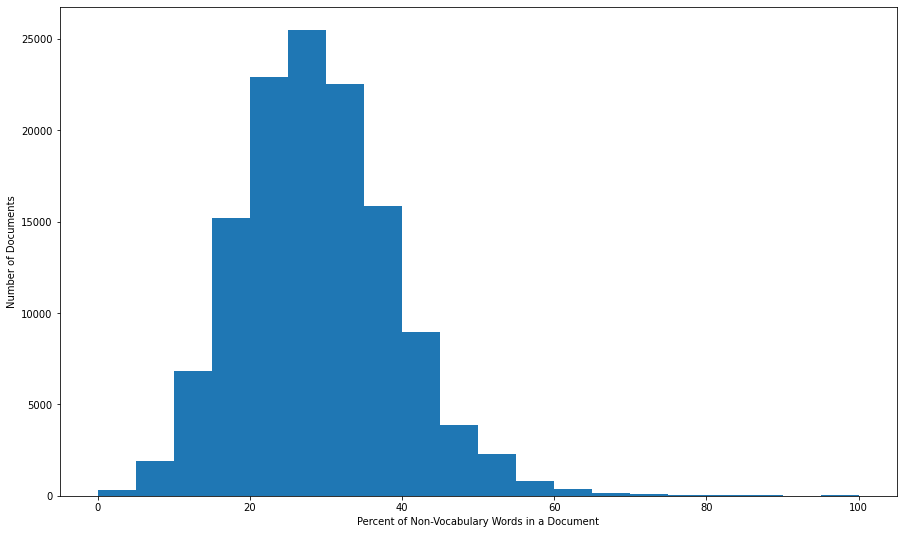

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [ ]:
print(f"There are {count1500} top {len(vocab_1500)} vocabulary words in the corpus.")

There are 2810751 top 1500 vocabulary words in the corpus.


In [ ]:
num_classes = 4
model = tf.keras.Sequential([
                              encoder_1500
                              ,tf.keras.layers.Embedding(input_dim=len(encoder_1500.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 258s 139ms/step - loss: 0.7172 - accuracy: 0.7233 - val_loss: 0.4768 - val_accuracy: 0.8372
Epoch 2/200
1782/1782 [==============================] - 248s 139ms/step - loss: 0.4461 - accuracy: 0.8454 - val_loss: 0.4399 - val_accuracy: 0.8478
Epoch 3/200
1782/1782 [==============================] - 249s 140ms/step - loss: 0.4064 - accuracy: 0.8577 - val_loss: 0.3949 - val_accuracy: 0.8652
Epoch 4/200
1782/1782 [==============================] - 250s 140ms/step - loss: 0.3782 - accuracy: 0.8669 - val_loss: 0.3722 - val_accuracy: 0.8710
Epoch 5/200
1782/1782 [==============================] - 250s 140ms/step - loss: 0.3592 - accuracy: 0.8721 - val_loss: 0.3698 - val_accuracy: 0.8698
Epoch 6/200
1782/1782 [==============================] - 248s 139ms/step - loss: 0.3489 - accuracy: 0.8751 - val_loss: 0.3608 - val_accuracy: 0.8733
Epoch 7/200
1782/1782 [==============================] - 250s 140ms/step - loss: 0.3403 - accuracy: 0.8787

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 4s 37ms/step - loss: 0.3570 - accuracy: 0.8749
Test Loss: 0.3570491075515747
Test Accuracy: 0.8748683929443359


In [ ]:
preds = model.predict(test_dataset)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.27%,99.97%,0.29%,1.04%,99.89%,0.29%,0.51%,23.35%,94.77%,2.11%,100.00%,0.57%,0.67%,91.14%,99.91%
Sports,99.46%,0.00%,0.01%,98.74%,0.00%,0.09%,99.28%,71.29%,0.08%,0.12%,0.00%,0.67%,0.03%,2.56%,0.00%
Business,0.18%,0.02%,3.62%,0.20%,0.06%,13.97%,0.07%,0.17%,1.52%,93.00%,0.00%,0.25%,98.68%,2.14%,0.03%
Sci/Tech,0.09%,0.01%,96.08%,0.02%,0.04%,85.64%,0.13%,5.19%,3.63%,4.77%,0.00%,98.51%,0.63%,4.17%,0.06%


Vocabulary of 10,000

In [ ]:
%%time
encoder_10000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=10000)
encoder_10000.adapt(dataset_all.map(lambda text, label: text))
vocab_10000 = np.array(encoder_10000.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7f221ebd7680>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f221ebd7680>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f221ebd7680>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 1min 41s, sys: 11.2 s, total: 1min 52s
Wall time: 1min 22s


In [ ]:
vocab_10000[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U56')

In [ ]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
encoder_10000(example)

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([   2, 5958, 1287,   29,    3,  232, 1414,   14,   19, 2548,   18,
          2, 2435,    8,    2,  999])>

In [ ]:
for word in example.split():
  print(f'"{word}" is {"*not* " if word not in vocab_10000  else ""}in the vocabulary.')

"the" is in the vocabulary.
"dog" is in the vocabulary.
"ran" is in the vocabulary.
"after" is in the vocabulary.
"a" is in the vocabulary.
"red" is in the vocabulary.
"ball" is in the vocabulary.
"as" is in the vocabulary.
"it" is in the vocabulary.
"rolled" is in the vocabulary.
"by" is in the vocabulary.
"the" is in the vocabulary.
"hat" is in the vocabulary.
"on" is in the vocabulary.
"the" is in the vocabulary.
"ground." is *not* in the vocabulary.


In [ ]:
%%time
doc10000_sizes = []
corpus10000 = []
count10000=0
useless = 0
# stop = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  # stop+=1
  # if stop > 5: break
  enc_example = encoder_10000(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  # print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc10000_sizes.append(len(enc_example))
  corpus10000+=list(enc_example.numpy())

  count10000 += tf.math.count_nonzero(enc_example>1)

CPU times: user 8min 19s, sys: 9.3 s, total: 8min 29s
Wall time: 8min 21s


In [ ]:
Counter(percents).most_common(10)
np.unique(percents, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  50,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  64,  66,  67,  68,  69,  70,
         71,  72,  73,  75,  79,  80,  83,  87, 100]),
 array([21240,    45,  2104, 13518,  9840,  7383,  9447,  7506,  7562,
         6710,  6019,  5348,  6051,  2988,  3986,  3031,  2090,  2431,
         1724,  1722,  1077,  1169,   766,   653,   650,   500,   362,
          283,   179,   238,   153,   133,    99,   146,    15,    52,
           43,    22,    55,    13,    49,     5,    16,    24,    14,
           10,     7,     4,     3,    30,     2,     1,     6,     4,
            6,     4,    17,     3,     5,     1,     1,     7,     2,
            1,     1,     7,     1,     1,     5,     1,     2,     2,
            

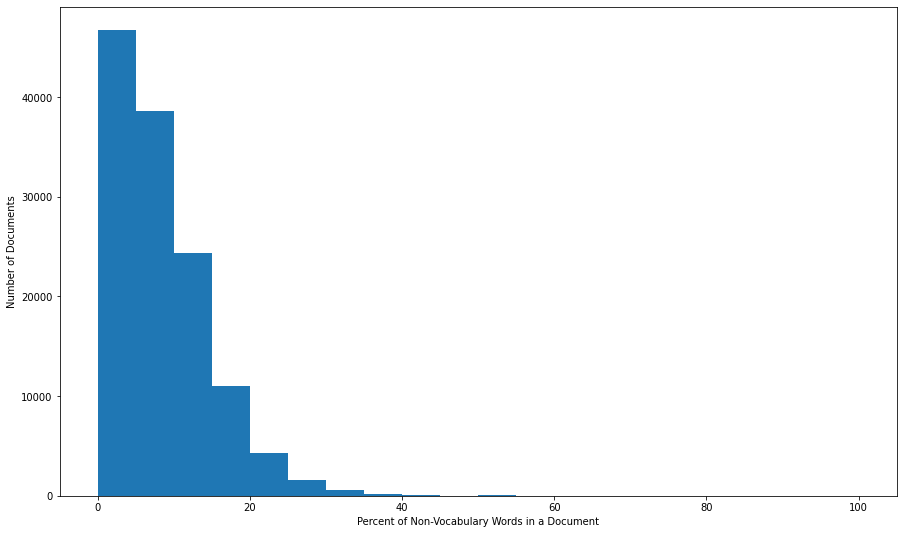

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [ ]:
print(f"There are {count10000} top {len(vocab_10000)} vocabulary words in the corpus.")

There are 3610024 top 10000 vocabulary words in the corpus.


In [ ]:
num_classes = 4
model = tf.keras.Sequential([
                              encoder_10000
                              ,tf.keras.layers.Embedding(input_dim=len(encoder_10000.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])


In [ ]:
history = model.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 274s 148ms/step - loss: 0.6068 - accuracy: 0.7860 - val_loss: 0.3501 - val_accuracy: 0.8847
Epoch 2/200
1782/1782 [==============================] - 262s 147ms/step - loss: 0.2995 - accuracy: 0.9007 - val_loss: 0.3083 - val_accuracy: 0.8997
Epoch 3/200
1782/1782 [==============================] - 261s 146ms/step - loss: 0.2491 - accuracy: 0.9170 - val_loss: 0.2956 - val_accuracy: 0.9015
Epoch 4/200
1782/1782 [==============================] - 261s 147ms/step - loss: 0.2196 - accuracy: 0.9261 - val_loss: 0.2974 - val_accuracy: 0.8998
Epoch 5/200
1782/1782 [==============================] - 260s 146ms/step - loss: 0.2009 - accuracy: 0.9315 - val_loss: 0.2920 - val_accuracy: 0.9052
Epoch 6/200
1782/1782 [==============================] - 260s 146ms/step - loss: 0.1862 - accuracy: 0.9366 - val_loss: 0.3004 - val_accuracy: 0.9042
Epoch 7/200
1782/1782 [==============================] - 261s 147ms/step - loss: 0.1748 - accuracy: 0.9406

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 5s 38ms/step - loss: 0.3185 - accuracy: 0.8986
Test Loss: 0.3185405731201172
Test Accuracy: 0.898552656173706


In [ ]:
preds = model.predict(test_dataset)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.02%,100.00%,0.12%,0.05%,97.70%,0.07%,0.02%,1.07%,100.00%,2.15%,100.00%,0.05%,0.04%,99.90%,100.00%
Sports,99.96%,0.00%,0.00%,99.94%,0.00%,0.01%,99.95%,98.90%,0.00%,0.01%,0.00%,0.00%,0.00%,0.09%,0.00%
Business,0.02%,0.00%,0.80%,0.00%,0.47%,1.37%,0.02%,0.02%,0.00%,97.50%,0.00%,0.06%,99.76%,0.00%,0.00%
Sci/Tech,0.00%,0.00%,99.08%,0.00%,1.83%,98.55%,0.01%,0.01%,0.00%,0.34%,0.00%,99.89%,0.19%,0.00%,0.00%


(b) Editing the Vocabulary: Try unedited most frequent words, VS edit the list by deleting the most frequent words such as articles, ‘the’, ‘a’, etc.

In [ ]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

1000

In [ ]:
vocab.shape

(1000,)

In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
vocab_wo_stop = [word for word in vocab if not word in stop_words]

In [ ]:
len(vocab_wo_stop)

898

In [ ]:
len(vocab)

1000

In [ ]:
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

In [ ]:
# See vocabulary without the common "stop-words"
vocab_wo_stop[:20]

['',
 '[UNK]',
 '39s',
 'said',
 'new',
 'us',
 'reuters',
 'ap',
 'two',
 'first',
 'monday',
 'wednesday',
 'tuesday',
 'thursday',
 'company',
 'friday',
 'inc',
 'one',
 'world',
 'yesterday']

In [ ]:
VOCAB_SIZE=1000
encoder_wo_stop = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, vocabulary = vocab_wo_stop)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
num_classes = 4
model = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 246s 133ms/step - loss: 0.7463 - accuracy: 0.7164 - val_loss: 0.5074 - val_accuracy: 0.8273
Epoch 2/200
1782/1782 [==============================] - 224s 125ms/step - loss: 0.4651 - accuracy: 0.8347 - val_loss: 0.4326 - val_accuracy: 0.8495
Epoch 3/200
1782/1782 [==============================] - 222s 124ms/step - loss: 0.4221 - accuracy: 0.8489 - val_loss: 0.4055 - val_accuracy: 0.8585
Epoch 4/200
1782/1782 [==============================] - 233s 130ms/step - loss: 0.4003 - accuracy: 0.8562 - val_loss: 0.3997 - val_accuracy: 0.8565
Epoch 5/200
1782/1782 [==============================] - 231s 130ms/step - loss: 0.3899 - accuracy: 0.8585 - val_loss: 0.3877 - val_accuracy: 0.8630
Epoch 6/200
1782/1782 [==============================] - 233s 130ms/step - loss: 0.3822 - accuracy: 0.8609 - val_loss: 0.3908 - val_accuracy: 0.8583
Epoch 7/200
1782/1782 [==============================] - 235s 132ms/step - loss: 0.3768 - accuracy: 0.8622

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 4s 32ms/step - loss: 0.4148 - accuracy: 0.8475
Test Loss: 0.414760559797287
Test Accuracy: 0.8475000262260437


In [ ]:
preds = model.predict(test_dataset)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.14%,99.86%,0.02%,0.66%,99.77%,0.23%,0.69%,21.65%,93.31%,2.50%,99.93%,0.58%,0.44%,93.79%,99.81%
Sports,99.72%,0.01%,0.00%,99.14%,0.01%,0.11%,99.04%,75.55%,0.45%,0.07%,0.00%,0.19%,0.05%,1.52%,0.00%
Business,0.07%,0.07%,0.60%,0.06%,0.09%,10.57%,0.05%,0.15%,1.46%,78.35%,0.04%,0.47%,98.69%,2.12%,0.08%
Sci/Tech,0.08%,0.05%,99.37%,0.13%,0.13%,89.08%,0.21%,2.66%,4.78%,19.08%,0.03%,98.75%,0.83%,2.56%,0.11%


(c) Output sequence length: Use the default VS set it to a fixed number


In [ ]:
%%time
encoder_1000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000, output_sequence_length=40)
encoder_1000.adapt(dataset_all.map(lambda text, label: text))
vocab_1000 = np.array(encoder_1000.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7f9a6f41e290>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f9a6f41e290>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f9a6f41e290>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 1min 40s, sys: 11.6 s, total: 1min 52s
Wall time: 1min 22s


In [ ]:
vocab_1000[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

In [ ]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
encoder_1000(example)

<tf.Tensor: shape=(40,), dtype=int64, numpy=
array([  2,   1,   1,  29,   3, 232,   1,  14,  19,   1,  18,   2,   1,
         8,   2, 999,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0])>

In [ ]:
for word in example.split():
  print(f'"{word}" is {"*not* " if word not in vocab_1000  else ""}in the vocabulary.')

"the" is in the vocabulary.
"dog" is *not* in the vocabulary.
"ran" is *not* in the vocabulary.
"after" is in the vocabulary.
"a" is in the vocabulary.
"red" is in the vocabulary.
"ball" is *not* in the vocabulary.
"as" is in the vocabulary.
"it" is in the vocabulary.
"rolled" is *not* in the vocabulary.
"by" is in the vocabulary.
"the" is in the vocabulary.
"hat" is *not* in the vocabulary.
"on" is in the vocabulary.
"the" is in the vocabulary.
"ground." is *not* in the vocabulary.


In [ ]:
num_classes = 4
model = tf.keras.Sequential([
                              encoder_1000
                              ,tf.keras.layers.Embedding(input_dim=len(encoder_1000.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 156s 82ms/step - loss: 0.7613 - accuracy: 0.7050 - val_loss: 0.4971 - val_accuracy: 0.8307
Epoch 2/200
1782/1782 [==============================] - 143s 80ms/step - loss: 0.4510 - accuracy: 0.8428 - val_loss: 0.4287 - val_accuracy: 0.8488
Epoch 3/200
1782/1782 [==============================] - 143s 80ms/step - loss: 0.4155 - accuracy: 0.8517 - val_loss: 0.4164 - val_accuracy: 0.8553
Epoch 4/200
1782/1782 [==============================] - 144s 81ms/step - loss: 0.4026 - accuracy: 0.8554 - val_loss: 0.4064 - val_accuracy: 0.8577
Epoch 5/200
1782/1782 [==============================] - 143s 80ms/step - loss: 0.3949 - accuracy: 0.8574 - val_loss: 0.3991 - val_accuracy: 0.8598
Epoch 6/200
1782/1782 [==============================] - 143s 80ms/step - loss: 0.3893 - accuracy: 0.8592 - val_loss: 0.3957 - val_accuracy: 0.8608
Epoch 7/200
1782/1782 [==============================] - 145s 81ms/step - loss: 0.3859 - accuracy: 0.8596 - val_

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 3s 21ms/step - loss: 0.4194 - accuracy: 0.8446
Test Loss: 0.4193532168865204
Test Accuracy: 0.8446052670478821
